In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
partition = 'milano'  # For LCLS II staff

cluster = SLURMCluster(
    queue=partition,
    account="lcls:data",
    local_directory='/sdf/home/m/monarin/tmp/',  # Local disk space for workers to use

    # Resources per SLURM job (per node, the way SLURM is configured on Roma)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 32 GB RAM.
    processes=4, cores=4, memory='512GB',
)

In [2]:
cluster.scale(jobs=1)
cluster.job_script()

In [3]:
client = Client(cluster)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 376.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34081,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 376.23 GiB
Comm: tcp://127.0.0.1:36641,Total threads: 4
Dashboard: http://127.0.0.1:38211/status,Memory: 376.23 GiB
Nanny: tcp://127.0.0.1:41711,


In [ ]:
client

In [4]:
%%bash
hostname
ifconfig

sdfiana002
enp175s0np0: flags=4163<UP,BROADCAST,RUNNING,MULTICAST>  mtu 9000
        inet 172.24.49.12  netmask 255.255.240.0  broadcast 172.24.63.255
        inet6 fe80::526b:4bff:fec7:5f10  prefixlen 64  scopeid 0x20<link>
        ether 50:6b:4b:c7:5f:10  txqueuelen 1000  (Ethernet)
        RX packets 5077666294  bytes 2732140379368 (2.4 TiB)
        RX errors 0  dropped 57  overruns 0  frame 0
        TX packets 3803847029  bytes 15503472121313 (14.1 TiB)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

enp24s0f0: flags=4099<UP,BROADCAST,MULTICAST>  mtu 1500
        ether ac:1f:6b:0f:94:ec  txqueuelen 1000  (Ethernet)
        RX packets 0  bytes 0 (0.0 B)
        RX errors 0  dropped 0  overruns 0  frame 0
        TX packets 0  bytes 0 (0.0 B)
        TX errors 0  dropped 0 overruns 0  carrier 0  collisions 0

enp24s0f1: flags=4099<UP,BROADCAST,MULTICAST>  mtu 1500
        ether ac:1f:6b:0f:94:ed  txqueuelen 1000  (Ethernet)
        RX packets 0  bytes 0 (0.0 B)
 

In [5]:
import time

In [6]:
import random

In [7]:
def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [8]:
%time costly_simulation([1,2,3,4])

CPU times: user 27.9 ms, sys: 4.68 ms, total: 32.6 ms
Wall time: 551 ms


10

In [9]:
import pandas as pd

In [10]:
import numpy as np

In [11]:
input_params = pd.DataFrame(np.random.random(size=(500,4)), columns=['param_a','param_b','param_c','param_d'])

In [12]:
input_params.head()

,param_a,param_b,param_c,param_d
0,0.648359,0.172160,0.845625,0.980714
1,0.720067,0.647428,0.518908,0.887318
2,0.174007,0.247952,0.397423,0.381864
3,0.809053,0.310459,0.273511,0.088390
4,0.720249,0.225389,0.433992,0.512750


In [13]:
results = []

In [14]:
%%time
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 241 ms, sys: 25.7 ms, total: 267 ms
Wall time: 4.86 s


In [15]:
import dask
lazy_results = []

In [16]:
%%time
for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 1.56 ms, sys: 929 µs, total: 2.49 ms
Wall time: 2.11 ms


In [17]:
lazy_results[0]

Delayed('costly_simulation-dd93acf8-116c-44d8-b05a-6f97aa8e41f4')

In [18]:
%time dask.compute(*lazy_results)

CPU times: user 195 ms, sys: 9.51 ms, total: 204 ms
Wall time: 1.8 s


(2.646857736624339,
 2.7737221571224886,
 1.2012467445403396,
 1.48141294882525,
 1.8923809125392919,
 1.4275354740636876,
 2.061915999171384,
 1.9857291954843885,
 2.4751255326947796,
 2.3999693760834955)

In [19]:
lazy_results = []
for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)
futures = dask.persist(*lazy_results)

In [14]:
client.cluster.scale(10)

In [21]:
results = dask.compute(*futures)
results[:5]

(2.646857736624339,
 2.7737221571224886,
 1.2012467445403396,
 1.48141294882525,
 1.8923809125392919)

In [22]:
futures = []
for parameters in input_params.values:
    future = client.submit(costly_simulation, parameters)
    futures.append(future)

In [23]:
results = client.gather(futures)
results[:5]

[2.646857736624339,
 2.7737221571224886,
 1.2012467445403396,
 1.48141294882525,
 1.8923809125392919]

In [24]:
futures = client.map(costly_simulation, input_params.values)

In [25]:
results = client.gather(futures)
len(results)

500

In [26]:
results[0]

2.646857736624339

In [27]:
output = input_params.copy()
output['result'] = pd.Series(results, index=output.index)
output.sample(5)

,param_a,param_b,param_c,param_d,result
46,0.219873,0.463134,0.965479,0.462386,2.110872
395,0.205873,0.162233,0.438948,0.575129,1.382182
251,0.882653,0.385140,0.864915,0.223041,2.355749
119,0.832231,0.525537,0.872696,0.678909,2.909372
38,0.872030,0.833996,0.834435,0.632188,3.172649


<Axes: >

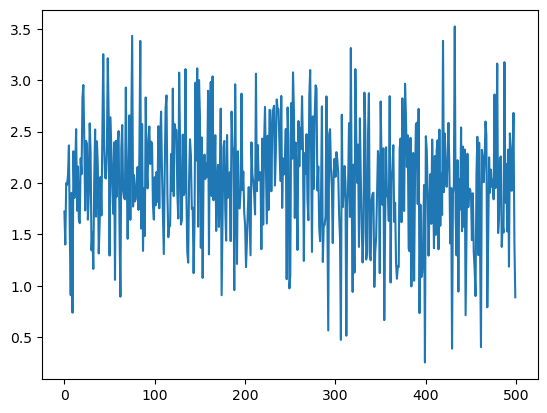

In [29]:
%matplotlib inline
output['result'].plot()

In [30]:
output['result'].mean()

2.0083184134006746

In [31]:
filtered_output = output[output['result'] > 2]
print(len(filtered_output))
filtered_output.to_csv('/tmp/simulation_result.csv')

255


In [33]:
import dask.bag as db
b = db.from_sequence(list(input_params.values), npartitions=100)
b = b.map(costly_simulation)

In [34]:
%time results_bag =b.compute()

CPU times: user 1.55 s, sys: 261 ms, total: 1.81 s
Wall time: 9.31 s


In [35]:
np.all(results) == np.all(results_bag)

True